# Bayesian Model Selection

## Introduction

In many inverse problems, we face not only uncertainty in **parameter values** but also uncertainty about the **model structure** itself. For example:

- How many layers exist in a subsurface velocity model?
- How many fault segments are needed to explain GPS data?
- What is the polynomial degree needed to fit a trend?
- How many change-points exist in a time series?

**Bayesian model selection** provides a principled framework for comparing models with different numbers of parameters and determining which model is most supported by the data, while naturally accounting for model complexity.

### The Model Selection Problem

Consider a set of competing models $\mathcal{M} = \{M_1, M_2, ..., M_K\}$, where:
- Each model $M_k$ has parameters $\mathbf{m}_k$ with dimension $n_k$
- The dimensions may differ: $n_1 \neq n_2 \neq ... \neq n_K$

Our goals:
1. **Model comparison**: Which model best explains the data?
2. **Model averaging**: Account for model uncertainty in predictions
3. **Joint inference**: Estimate both the model structure AND parameters

### Traditional Approach: Separate Analysis

A common but suboptimal approach:
1. Fit each model independently using MCMC
2. Compare models using information criteria (AIC, BIC) or Bayes factors
3. Select the "best" model
4. Report parameter estimates for that model only

**Problems**:
- Ignores model uncertainty
- Selection bias in parameter estimates
- Arbitrary threshold for model choice
- Can't naturally propagate uncertainty across models

## Bayesian Framework for Model Selection

In the Bayesian framework, we treat the model index $k$ as an unknown variable and compute the **joint posterior distribution**:

$$p(k, \mathbf{m}_k | \mathbf{d}) \propto p(\mathbf{d} | \mathbf{m}_k, k) \cdot p(\mathbf{m}_k | k) \cdot p(k)$$

where:
- $p(k)$ is the **prior probability** of model $k$
- $p(\mathbf{m}_k | k)$ is the **parameter prior** given model $k$
- $p(\mathbf{d} | \mathbf{m}_k, k)$ is the **likelihood** for model $k$
- $p(k, \mathbf{m}_k | \mathbf{d})$ is the **joint posterior** over models and parameters

### Marginal Posteriors

We can extract different information from the joint posterior:

**1. Model posterior probabilities:**
$$p(k | \mathbf{d}) = \int p(k, \mathbf{m}_k | \mathbf{d}) \, d\mathbf{m}_k$$

This tells us which model is most probable given the data.

**2. Parameter posterior given a model:**
$$p(\mathbf{m}_k | k, \mathbf{d}) = \frac{p(k, \mathbf{m}_k | \mathbf{d})}{p(k | \mathbf{d})}$$

**3. Model-averaged parameter posterior:**
$$p(\mathbf{m} | \mathbf{d}) = \sum_{k=1}^K p(\mathbf{m}_k | k, \mathbf{d}) \cdot p(k | \mathbf{d})$$

This accounts for uncertainty about which model is correct.

### Bayes Factors and Model Evidence

The **Bayes factor** comparing models $i$ and $j$ is:

$$\text{BF}_{ij} = \frac{p(k=i | \mathbf{d})}{p(k=j | \mathbf{d})} \cdot \frac{p(k=j)}{p(k=i)} = \frac{p(\mathbf{d} | k=i)}{p(\mathbf{d} | k=j)}$$

where the **model evidence** (or marginal likelihood) is:

$$p(\mathbf{d} | k) = \int p(\mathbf{d} | \mathbf{m}_k, k) \cdot p(\mathbf{m}_k | k) \, d\mathbf{m}_k$$

The evidence automatically implements **Occam's razor**: complex models are penalized because they spread prior probability mass over a larger parameter space, leading to lower average likelihood.

## The Challenge: Trans-Dimensional Sampling

The key challenge in Bayesian model selection is that we need to sample from a distribution where **the dimension of the parameter space changes** with the model index.

### Why Standard MCMC Fails

Standard Metropolis-Hastings requires:
- A fixed-dimensional parameter space
- Proposal distributions that preserve dimensionality
- Acceptance ratios that compare states in the same space

When $\dim(\mathbf{m}_1) \neq \dim(\mathbf{m}_2)$, we can't directly propose moves between models because the parameter vectors have different lengths!

### Solutions

1. **Separate chains + Post-processing**: Run independent MCMC for each model, compute evidence separately, combine results
   - Simple but computationally expensive
   - Difficult to compute evidence accurately
   
2. **Product Space Method**: Embed all models in a single high-dimensional space
   - Inefficient; wastes dimensions
   
3. **Reversible-Jump MCMC (RJMCMC)**: Extend MCMC to trans-dimensional spaces
   - Elegant and efficient
   - Gold standard for Bayesian model selection

## Reversible-Jump MCMC (RJMCMC)

**Reversible-Jump MCMC**, introduced by Peter Green (1995), extends the Metropolis-Hastings algorithm to handle trans-dimensional problems. It's a elegant framework that allows the Markov chain to "jump" between parameter spaces of different dimensions.

### Key Idea: Dimension Matching

To propose a move from model $k$ with parameters $\mathbf{m}_k \in \mathbb{R}^{n_k}$ to model $k'$ with parameters $\mathbf{m}_{k'} \in \mathbb{R}^{n_{k'}}$:

1. **Generate random numbers** $\mathbf{u} \sim q(\mathbf{u})$ to "pad" the dimension if needed
2. **Apply a bijection** (one-to-one mapping) to match dimensions:
   $$(\mathbf{m}_{k'}, \mathbf{u}') = T(\mathbf{m}_k, \mathbf{u})$$
   where $n_k + \dim(\mathbf{u}) = n_{k'} + \dim(\mathbf{u}')$
3. **Accept/reject** using a modified Metropolis ratio that includes a Jacobian term

### The RJMCMC Acceptance Ratio

For a proposed jump from $(k, \mathbf{m}_k)$ to $(k', \mathbf{m}_{k'})$:

$$\alpha = \min\left(1, \underbrace{\frac{p(\mathbf{d} | \mathbf{m}_{k'}, k')}{p(\mathbf{d} | \mathbf{m}_k, k)}}_{\text{Likelihood ratio}} \cdot \underbrace{\frac{p(\mathbf{m}_{k'} | k')}{p(\mathbf{m}_k | k)}}_{\text{Prior ratio}} \cdot \underbrace{\frac{p(k')}{p(k)}}_{\text{Model prior}} \cdot \underbrace{\frac{q_{k \to k'}}{q_{k' \to k}}}_{\text{Proposal ratio}} \cdot \underbrace{\left|\frac{\partial T}{\partial(\mathbf{m}_k, \mathbf{u})}\right|}_{\text{Jacobian}}\right)$$

The **Jacobian term** ensures detailed balance is satisfied in the trans-dimensional space. It accounts for how volume changes under the transformation.

### Special Case: Dimension Matching Without Transformation

If we can directly construct $\mathbf{m}_{k'}$ by adding or removing parameters:

**Birth move** ($n_k \to n_k + 1$): Generate new parameter(s) from proposal distribution
$$\mathbf{m}_{k'} = [\mathbf{m}_k; m_{\text{new}}], \quad m_{\text{new}} \sim q_{\text{birth}}$$

**Death move** ($n_k \to n_k - 1$): Remove parameter(s)
$$\mathbf{m}_{k'} = \mathbf{m}_k[1:n_{k'}]$$

The Jacobian simplifies, and the acceptance ratio becomes:
$$\alpha_{\text{birth}} = \min\left(1, \frac{p(\mathbf{d} | \mathbf{m}_{k'}, k') \cdot p(\mathbf{m}_{k'} | k') \cdot p(k')}{p(\mathbf{d} | \mathbf{m}_k, k) \cdot p(\mathbf{m}_k | k) \cdot p(k)} \cdot \frac{q_{\text{death}}}{q_{\text{birth}}(m_{\text{new}})}\right)$$

## RJMCMC Algorithm Structure

A typical RJMCMC sampler alternates between two types of moves:

### Move Type 1: Within-Model Updates (Fixed Dimension)

Standard Metropolis-Hastings updates for parameters within the current model $k$:

```
Current state: (k, m_k)
Propose: m_k' ~ q(· | m_k) 
Accept with probability: α = min(1, likelihood_ratio × prior_ratio × proposal_ratio)
```

This is just regular MCMC and typically dominates the computational cost.

### Move Type 2: Between-Model Jumps (Trans-Dimensional)

Propose to change the model (and parameter dimension):

```
Current state: (k, m_k)

# Randomly select target model k' ≠ k
k' ~ p_jump(· | k)

# Dimension matching
IF n_k' > n_k:  # Birth/expansion
    Generate u ~ q(u)  (new parameter values or auxiliary variables)
    Construct m_k' using T(m_k, u)
    
ELIF n_k' < n_k:  # Death/reduction
    Extract m_k' from m_k
    Compute u' (the "discarded" components)
    
ELSE:  # Same dimension, different parameterization
    Apply bijection T
    
# Compute acceptance probability with Jacobian
α = min(1, [posterior_ratio] × [proposal_ratio] × |Jacobian|)

# Accept or reject
IF random() < α:
    Update to (k', m_k')
ELSE:
    Stay at (k, m_k)
```

### Proposal Probabilities

Choose how often to attempt different move types:
- **Within-model**: High frequency (e.g., 80-95% of iterations)
- **Between-model**: Lower frequency (e.g., 5-20% of iterations)
- Among between-model moves, can weight by model similarity or use uniform probabilities

## Detailed RJMCMC Pseudo-Code

```python
INITIALIZE:
    Set initial model k and parameters m_k
    Set prior probabilities p(k) for each model
    Set within-model proposal distributions q_within(·|m, k)
    Set between-model jump probabilities p_jump(k'|k)
    Set birth/death proposal distributions
    Set move probabilities: prob_within, prob_between
    
FOR iteration = 1 to N_iterations:
    
    # Decide move type
    IF random() < prob_within:
        # ========================================
        # WITHIN-MODEL UPDATE (standard MH)
        # ========================================
        m_proposed = PROPOSAL_WITHIN(m_k, k)
        
        log_likelihood_ratio = log(p(d | m_proposed, k)) - log(p(d | m_k, k))
        log_prior_ratio = log(p(m_proposed | k)) - log(p(m_k | k))
        log_proposal_ratio = log(q(m_k | m_proposed)) - log(q(m_proposed | m_k))
        
        log_alpha = log_likelihood_ratio + log_prior_ratio + log_proposal_ratio
        
        IF log(random()) < log_alpha:
            m_k = m_proposed
            accept_within[k] += 1
            
    ELSE:
        # ========================================
        # BETWEEN-MODEL JUMP (trans-dimensional)
        # ========================================
        
        # Propose target model
        k_proposed = SAMPLE_MODEL(p_jump(·|k))
        
        n_k = dimension(m_k)
        n_k_prop = dimension_of_model(k_proposed)
        
        # Dimension matching transformation
        IF n_k_prop > n_k:  # BIRTH MOVE
            # Generate new parameters
            u = SAMPLE_FROM_BIRTH_PROPOSAL(k, k_proposed)
            m_k_prop = CONSTRUCT_EXPANDED_MODEL(m_k, u)
            
            # Jacobian (often = 1 for simple birth/death)
            log_jacobian = 0  # or compute actual Jacobian if using transformation
            
            # Proposal ratio includes birth proposal density
            log_proposal_ratio = (log(p_jump(k|k_proposed)) + log(q_death) 
                                 - log(p_jump(k_proposed|k)) - log(q_birth(u)))
            
        ELIF n_k_prop < n_k:  # DEATH MOVE
            # Remove parameters
            m_k_prop, u_discarded = EXTRACT_REDUCED_MODEL(m_k)
            
            log_jacobian = 0
            
            # Proposal ratio
            log_proposal_ratio = (log(p_jump(k|k_proposed)) + log(q_birth(u_discarded))
                                 - log(p_jump(k_proposed|k)) - log(q_death))
            
        ELSE:  # SAME DIMENSION, DIFFERENT PARAMETERIZATION
            # Apply bijection with auxiliary variables
            u = SAMPLE_AUX_VARIABLES()
            m_k_prop, u_prop = BIJECTION(m_k, u)
            
            log_jacobian = log(|det(∂(m_k_prop, u_prop)/∂(m_k, u))|)
            log_proposal_ratio = (log(p_jump(k|k_proposed)) + log(q(u_prop))
                                 - log(p_jump(k_proposed|k)) - log(q(u)))
        
        # Compute acceptance probability
        log_likelihood_ratio = log(p(d | m_k_prop, k_proposed)) - log(p(d | m_k, k))
        log_prior_ratio = log(p(m_k_prop | k_proposed)) - log(p(m_k | k))
        log_model_prior_ratio = log(p(k_proposed)) - log(p(k))
        
        log_alpha = (log_likelihood_ratio + log_prior_ratio + 
                    log_model_prior_ratio + log_proposal_ratio + log_jacobian)
        
        IF log(random()) < log_alpha:
            k = k_proposed
            m_k = m_k_prop
            accept_between[k, k_proposed] += 1
    
    # Store sample
    samples_k[iteration] = k
    samples_m[iteration] = m_k  # (store in flexible structure)
    
END FOR

# Post-processing
model_probabilities = COMPUTE_MODEL_FREQUENCIES(samples_k, burn_in)
parameter_estimates = COMPUTE_CONDITIONAL_POSTERIORS(samples_m, samples_k)

RETURN samples_k, samples_m, model_probabilities, parameter_estimates
```

## Practical Considerations for RJMCMC

### 1. Designing Good Proposals

**Challenge**: Between-model moves often have low acceptance rates.

**Solutions**:
- **Prior-based proposals**: Sample new parameters from the prior
  - Simple but can have very low acceptance if prior and posterior differ
  
- **Data-informed proposals**: Use approximations to the posterior for new parameters
  - Higher acceptance but requires more computation
  
- **Local proposals**: Only change model structure locally (e.g., add/remove one component at a time)
  - More gradual exploration
  
- **Delayed rejection**: If jump fails, try modified proposal before giving up

### 2. Label Switching / Model Identification

When models have symmetric parameterizations (e.g., mixture components, layer ordering), the sampler can switch labels, making interpretation difficult.

**Solutions**:
- Post-process using clustering or relabeling algorithms
- Impose ordering constraints (e.g., $m_1 < m_2 < ... < m_k$)
- Use informative priors that break symmetry

### 3. Tuning and Diagnostics

**Acceptance rates**:
- Within-model: Target 20-40% (standard MH guideline)
- Between-model: Often much lower (5-30% acceptable)
- If between-model acceptance is too low, models may not mix well

**Convergence checks**:
- Model visit frequencies should stabilize after burn-in
- Multiple chains should converge to similar model probabilities
- Geweke diagnostics within each model
- Visual inspection of model trajectory over iterations

### 4. Computational Efficiency

**Bottlenecks**:
- Likelihood evaluations dominate cost
- Need to compute likelihood for every proposed state

**Optimizations**:
- Cache likelihoods when possible
- Use parallel tempering with RJMCMC for better mixing
- Delayed acceptance: cheap approximation first, expensive exact likelihood only if needed
- Adaptive proposals: learn good proposal distributions during burn-in

### 5. Prior Sensitivity

RJMCMC can be sensitive to:
- **Model priors** $p(k)$: Strong preference can override data
- **Parameter priors** $p(\mathbf{m}_k|k)$: Affect evidence via prior-posterior overlap

**Best practices**:
- Use weakly informative priors when possible
- Test sensitivity by varying prior assumptions
- Report prior predictive distributions
- Consider empirical Bayes for hyperparameters

## Interpreting RJMCMC Results

After running RJMCMC, we extract several types of information from the samples:

### 1. Model Posterior Probabilities

Count the frequency of each model in the post-burn-in samples:

$$\hat{p}(k|\mathbf{d}) = \frac{\text{Number of samples with model } k}{\text{Total number of samples}}$$

**Interpretation**:
- $p(k|\mathbf{d}) > 0.95$: Strong evidence for model $k$
- $0.75 < p(k|\mathbf{d}) < 0.95$: Moderate evidence
- $p(k|\mathbf{d}) < 0.75$: Substantial model uncertainty

If no single model dominates, **don't pick one**—use model averaging!

### 2. Model-Specific Parameter Posteriors

For each model $k$, extract samples where model $k$ was active:

$$p(\mathbf{m}_k | k, \mathbf{d}) \approx \text{histogram of } \{\mathbf{m}_k^{(i)} : k^{(i)} = k\}$$

These are the parameter estimates **conditional on model $k$ being correct**.

### 3. Model-Averaged Predictions

For making predictions $\mathbf{d}_{\text{pred}}$, average over model uncertainty:

$$p(\mathbf{d}_{\text{pred}} | \mathbf{d}) = \sum_{k=1}^K p(\mathbf{d}_{\text{pred}} | k, \mathbf{d}) \cdot p(k | \mathbf{d})$$

This properly accounts for structural uncertainty and typically gives wider (more realistic) prediction intervals.

### 4. Effective Dimension

The **effective number of parameters** is often less than the nominal dimension:

$$n_{\text{eff}} = \sum_{k=1}^K n_k \cdot p(k|\mathbf{d})$$

This provides insight into model complexity supported by the data.

### 5. Visualization

Useful plots include:
- **Model trajectory**: Show $k(t)$ over iterations (should mix between models)
- **Model frequency histogram**: Bar chart of $p(k|\mathbf{d})$
- **Parameter traces conditional on model**: Within-model mixing
- **Model-averaged parameter distributions**: Combined over all models
- **Prediction bands**: Show uncertainty from both parameters and model structure

---

## Example: Polynomial Model Selection with Analytical Evidence

We'll demonstrate Bayesian model selection on a simple but illustrative problem: determining the optimal polynomial degree to fit noisy data. This example is pedagogically valuable because:

1. The evidence (marginal likelihood) can be computed **analytically** using Bayesian linear regression
2. We can generate synthetic data with a known "true" polynomial order
3. We can test whether Bayesian selection correctly identifies the true model
4. We can visualize the automatic Occam's razor penalizing over-complex models

### Problem Setup

Given data points $(x_i, y_i)$ for $i = 1, ..., N$, we want to fit a polynomial:

$$y(x) = a_0 + a_1 x + a_2 x^2 + ... + a_k x^k + \epsilon$$

where $\epsilon \sim \mathcal{N}(0, \sigma^2)$ is observation noise.

**Models**: $M_k$ represents a polynomial of degree $k$ with parameters $\mathbf{a}_k = (a_0, a_1, ..., a_k)^T$

**Goal**: Determine which value of $k$ is best supported by the data using Bayesian model selection.

### Analytical Evidence for Bayesian Linear Regression

For polynomial regression with Gaussian priors and likelihood, the evidence has a **closed-form solution**.

**Likelihood** (assuming known noise variance $\sigma^2$):
$$p(\mathbf{y} | \mathbf{a}_k, k, \sigma^2) = \mathcal{N}(\mathbf{y} | \mathbf{X}_k \mathbf{a}_k, \sigma^2 \mathbf{I})$$

where $\mathbf{X}_k$ is the design matrix (Vandermonde matrix for polynomials).

**Prior on coefficients** (conjugate Gaussian prior):
$$p(\mathbf{a}_k | k, \alpha^2) = \mathcal{N}(\mathbf{a}_k | \mathbf{0}, \alpha^2 \mathbf{I})$$

where $\alpha^2$ controls prior strength (large $\alpha^2$ = weak prior).

**Posterior** (also Gaussian):
$$p(\mathbf{a}_k | \mathbf{y}, k) = \mathcal{N}(\mathbf{a}_k | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)$$

where:
- $\boldsymbol{\Sigma}_k = (\mathbf{X}_k^T \mathbf{X}_k / \sigma^2 + \mathbf{I}/\alpha^2)^{-1}$
- $\boldsymbol{\mu}_k = \boldsymbol{\Sigma}_k \mathbf{X}_k^T \mathbf{y} / \sigma^2$

**Evidence** (marginal likelihood):
$$p(\mathbf{y} | k, \sigma^2, \alpha^2) = \int p(\mathbf{y} | \mathbf{a}_k, k, \sigma^2) \cdot p(\mathbf{a}_k | k, \alpha^2) \, d\mathbf{a}_k$$

This integral is **analytically tractable** for Gaussian distributions:

$$\log p(\mathbf{y} | k) = -\frac{N}{2}\log(2\pi\sigma^2) - \frac{1}{2\sigma^2}\mathbf{y}^T\mathbf{y} + \frac{1}{2\sigma^2}\boldsymbol{\mu}_k^T \boldsymbol{\Sigma}_k^{-1} \boldsymbol{\mu}_k + \frac{1}{2}\log|\boldsymbol{\Sigma}_k| - \frac{k+1}{2}\log(2\pi\alpha^2)$$

This can be simplified using matrix identities to:

$$\log p(\mathbf{y} | k) = -\frac{N}{2}\log(2\pi) - \frac{N}{2}\log(\sigma^2) - \frac{1}{2}\log|\mathbf{A}_k| - \frac{1}{2\sigma^2}(\mathbf{y}^T\mathbf{y} - \mathbf{y}^T\mathbf{X}_k\mathbf{A}_k^{-1}\mathbf{X}_k^T\mathbf{y})$$

where $\mathbf{A}_k = \mathbf{X}_k^T\mathbf{X}_k + (\sigma^2/\alpha^2)\mathbf{I}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries loaded successfully!")

Libraries loaded successfully!


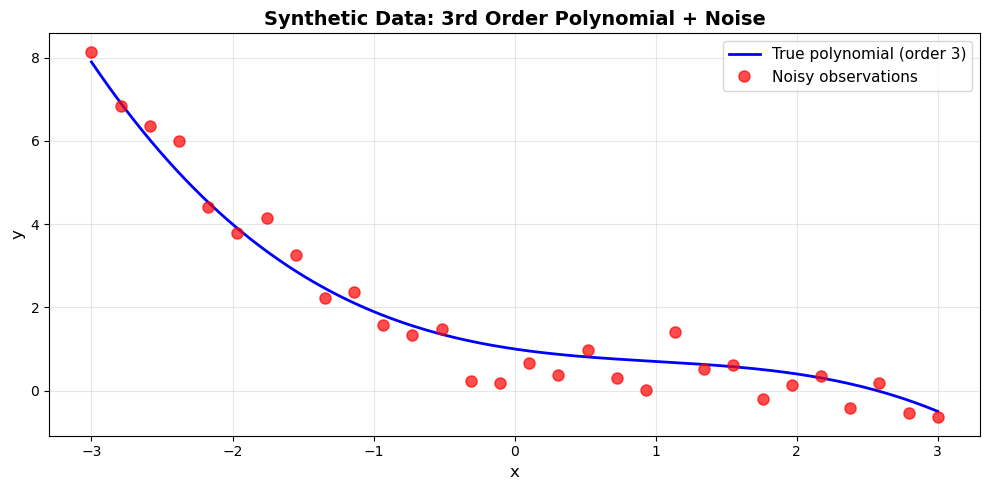

Generated 30 data points from a polynomial of order 3
True coefficients: [ 1.  -0.5  0.3 -0.1]
Noise standard deviation: σ = 0.5


In [2]:
# Generate synthetic data from a known polynomial

# True model: 3rd order polynomial
true_order = 3
true_coeffs = np.array([1.0, -0.5, 0.3, -0.1])  # a0, a1, a2, a3

# Generate x values
N = 30  # Number of data points
x = np.linspace(-3, 3, N)

# Generate true polynomial values
def eval_polynomial(x, coeffs):
    """Evaluate polynomial with given coefficients"""
    return np.sum([coeffs[i] * x**i for i in range(len(coeffs))], axis=0)

y_true = eval_polynomial(x, true_coeffs)

# Add Gaussian noise
sigma_true = 0.5  # True noise standard deviation
noise = np.random.normal(0, sigma_true, N)
y_obs = y_true + noise

# Visualize the data
plt.figure(figsize=(10, 5))
x_plot = np.linspace(-3, 3, 200)
y_plot_true = eval_polynomial(x_plot, true_coeffs)

plt.plot(x_plot, y_plot_true, 'b-', linewidth=2, label='True polynomial (order 3)')
plt.plot(x, y_obs, 'ro', markersize=8, label='Noisy observations', alpha=0.7)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Synthetic Data: 3rd Order Polynomial + Noise', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Generated {N} data points from a polynomial of order {true_order}")
print(f"True coefficients: {true_coeffs}")
print(f"Noise standard deviation: σ = {sigma_true}")

In [3]:
# Implement Bayesian linear regression with analytical evidence

def design_matrix(x, order):
    """Create Vandermonde design matrix for polynomial of given order"""
    N = len(x)
    X = np.zeros((N, order + 1))
    for i in range(order + 1):
        X[:, i] = x**i
    return X

def bayesian_polynomial_fit(x, y, order, sigma2, alpha2):
    """
    Bayesian polynomial regression with analytical posterior and evidence
    
    Parameters:
    -----------
    x : array
        Input data
    y : array
        Observed data
    order : int
        Polynomial order
    sigma2 : float
        Noise variance (assumed known)
    alpha2 : float
        Prior variance on coefficients
    
    Returns:
    --------
    mu : array
        Posterior mean of coefficients
    Sigma : array
        Posterior covariance matrix
    log_evidence : float
        Log marginal likelihood (evidence)
    """
    # Design matrix
    X = design_matrix(x, order)
    N = len(y)
    n_params = order + 1
    
    # Posterior covariance: Sigma = (X^T X / sigma2 + I / alpha2)^(-1)
    precision = X.T @ X / sigma2 + np.eye(n_params) / alpha2
    Sigma = np.linalg.inv(precision)
    
    # Posterior mean: mu = Sigma @ X^T @ y / sigma2
    mu = Sigma @ X.T @ y / sigma2
    
    # Compute log evidence analytically
    # log p(y|k) = -N/2 log(2π) - N/2 log(σ²) - 1/2 log|A_k| 
    #              - 1/(2σ²) (y^T y - y^T X A_k^{-1} X^T y)
    # where A_k = X^T X + (σ²/α²) I
    
    A_k = X.T @ X + (sigma2 / alpha2) * np.eye(n_params)
    
    # Components of log evidence
    term1 = -N / 2 * np.log(2 * np.pi)
    term2 = -N / 2 * np.log(sigma2)
    
    # Log determinant
    sign, logdet = np.linalg.slogdet(A_k)
    term3 = -0.5 * logdet
    
    # Quadratic term
    y_y = y.T @ y
    A_k_inv = np.linalg.inv(A_k)
    y_X_Ainv_Xt_y = y.T @ X @ A_k_inv @ X.T @ y
    term4 = -1 / (2 * sigma2) * (y_y - y_X_Ainv_Xt_y)
    
    log_evidence = term1 + term2 + term3 + term4
    
    return mu, Sigma, log_evidence

# Test on different polynomial orders
max_order = 8
sigma2 = sigma_true**2  # Assume we know the true noise variance
alpha2 = 10.0  # Prior variance (weakly informative)

results = {}
for k in range(max_order + 1):
    mu, Sigma, log_evidence = bayesian_polynomial_fit(x, y_obs, k, sigma2, alpha2)
    results[k] = {
        'mu': mu,
        'Sigma': Sigma,
        'log_evidence': log_evidence,
        'order': k
    }
    print(f"Order {k}: log evidence = {log_evidence:.2f}")

print(f"\nBest model by evidence: Order {max(results.keys(), key=lambda k: results[k]['log_evidence'])}")

Order 0: log evidence = -346.29
Order 1: log evidence = -89.15
Order 2: log evidence = -34.07
Order 3: log evidence = -26.22
Order 4: log evidence = -29.11
Order 5: log evidence = -32.99
Order 6: log evidence = -37.08
Order 7: log evidence = -41.80
Order 8: log evidence = -46.84

Best model by evidence: Order 3


Bayesian Model Selection Results:
Order    Log Evidence    Posterior Prob  Bayes Factor vs k=3 
0        -346.29         0.0000          9.85e-140           
1        -89.15          0.0000          4.67e-28            
2        -34.07          0.0004          3.87e-04            
3        -26.22          0.9460          1.00e+00             ← TRUE MODEL ← BEST
4        -29.11          0.0526          5.56e-02            
5        -32.99          0.0011          1.14e-03            
6        -37.08          0.0000          1.91e-05            
7        -41.80          0.0000          1.70e-07            
8        -46.84          0.0000          1.10e-09            

True polynomial order: 3
Selected order (MAP): 3
Posterior probability of true model: 94.6%


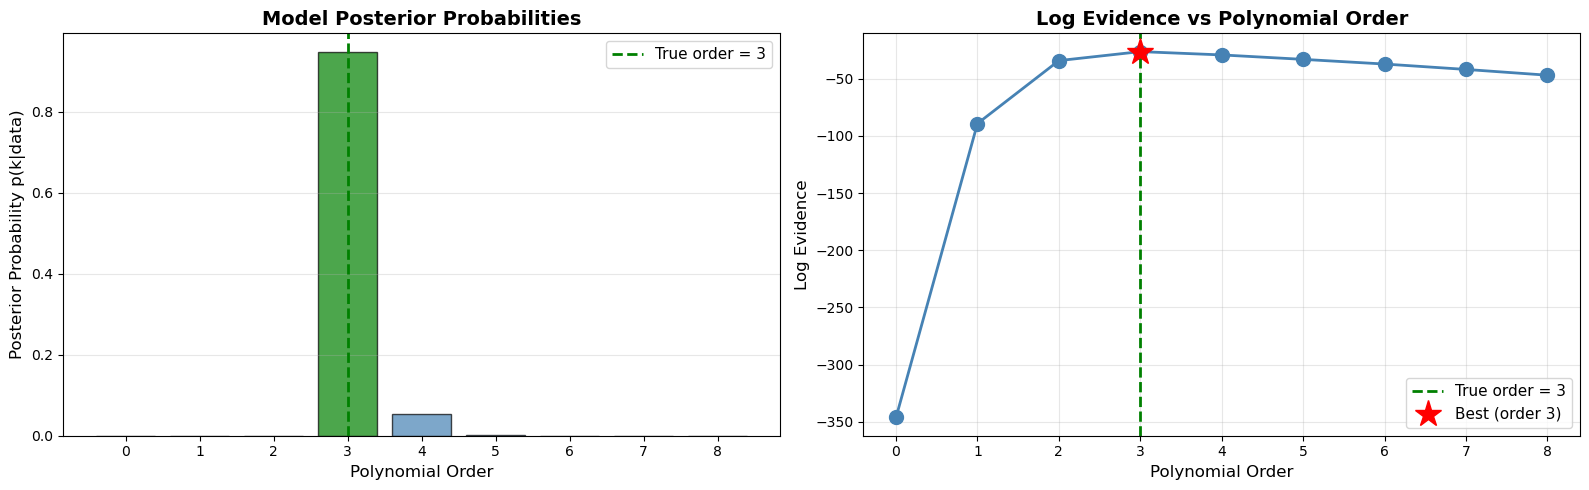

In [4]:
# Compute model posterior probabilities

# Extract log evidences
log_evidences = np.array([results[k]['log_evidence'] for k in range(max_order + 1)])

# Compute posterior probabilities assuming uniform model prior p(k) = 1/(max_order + 1)
# p(k|y) ∝ p(y|k) * p(k)
# With uniform prior: p(k|y) ∝ p(y|k)

# Use log-sum-exp trick for numerical stability
max_log_evidence = np.max(log_evidences)
evidences = np.exp(log_evidences - max_log_evidence)
posterior_probs = evidences / np.sum(evidences)

# Display results
print("Bayesian Model Selection Results:")
print("="*60)
print(f"{'Order':<8} {'Log Evidence':<15} {'Posterior Prob':<15} {'Bayes Factor vs k=3':<20}")
print("="*60)

for k in range(max_order + 1):
    bf = np.exp(results[k]['log_evidence'] - results[true_order]['log_evidence'])
    marker = " ← TRUE MODEL" if k == true_order else ""
    marker += " ← BEST" if k == np.argmax(posterior_probs) else ""
    print(f"{k:<8} {results[k]['log_evidence']:<15.2f} {posterior_probs[k]:<15.4f} {bf:<20.2e}{marker}")

print("="*60)
print(f"\nTrue polynomial order: {true_order}")
print(f"Selected order (MAP): {np.argmax(posterior_probs)}")
print(f"Posterior probability of true model: {posterior_probs[true_order]:.1%}")

# Visualize model posterior probabilities
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Bar chart of posterior probabilities
colors = ['green' if k == true_order else 'steelblue' for k in range(max_order + 1)]
bars = ax1.bar(range(max_order + 1), posterior_probs, color=colors, alpha=0.7, edgecolor='black')
ax1.axvline(true_order, color='green', linestyle='--', linewidth=2, label=f'True order = {true_order}')
ax1.set_xlabel('Polynomial Order', fontsize=12)
ax1.set_ylabel('Posterior Probability p(k|data)', fontsize=12)
ax1.set_title('Model Posterior Probabilities', fontsize=14, fontweight='bold')
ax1.set_xticks(range(max_order + 1))
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

# Log evidence vs order
ax2.plot(range(max_order + 1), log_evidences, 'o-', linewidth=2, markersize=10, color='steelblue')
ax2.axvline(true_order, color='green', linestyle='--', linewidth=2, label=f'True order = {true_order}')
best_order = np.argmax(log_evidences)
ax2.plot(best_order, log_evidences[best_order], 'r*', markersize=20, label=f'Best (order {best_order})')
ax2.set_xlabel('Polynomial Order', fontsize=12)
ax2.set_ylabel('Log Evidence', fontsize=12)
ax2.set_title('Log Evidence vs Polynomial Order', fontsize=14, fontweight='bold')
ax2.set_xticks(range(max_order + 1))
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

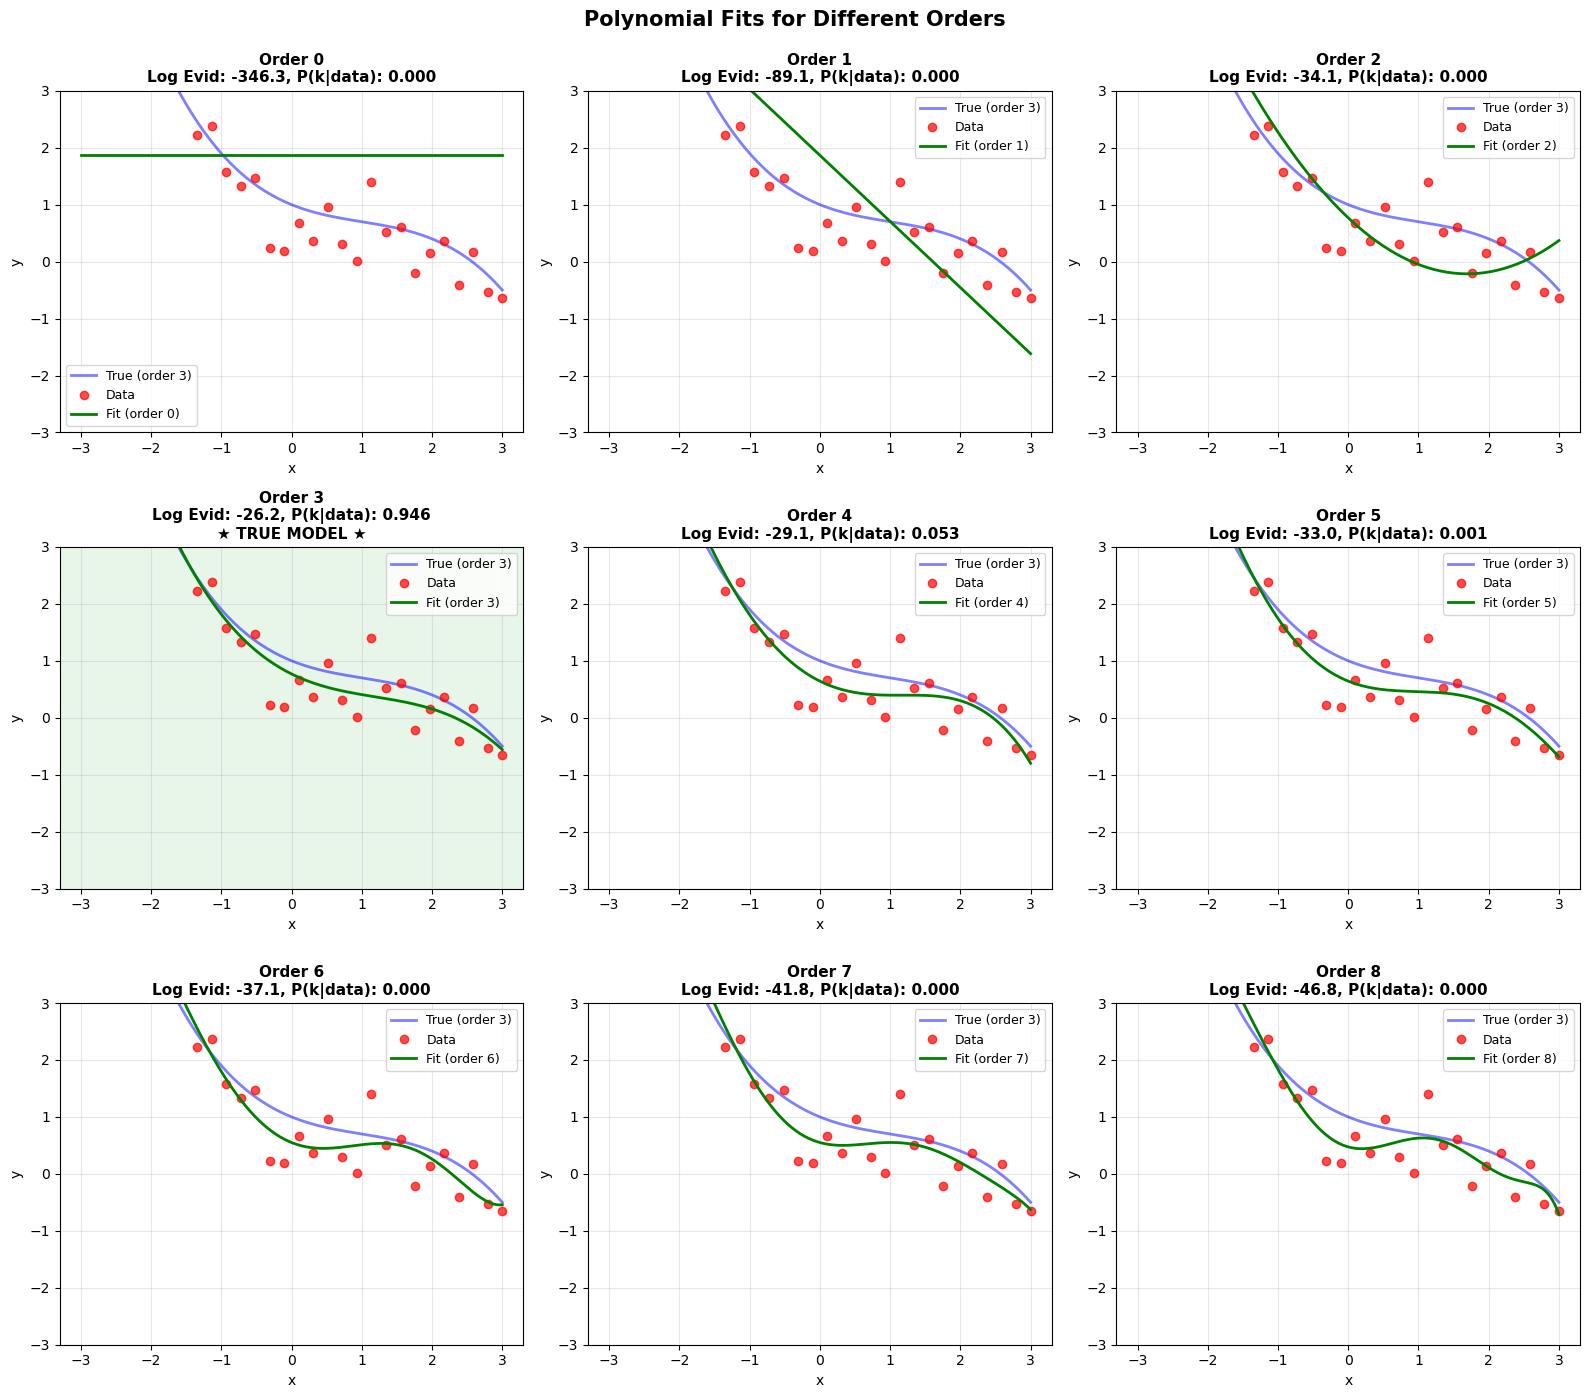


Observations:
- Orders < 3: Underfit (high bias, can't capture true complexity)
- Order = 3: Best model (captures true structure)
- Orders > 3: Overfit (low bias on training data, but penalized by evidence)

The evidence automatically penalizes overly complex models!


In [5]:
# Visualize fitted polynomials for different orders

fig, axes = plt.subplots(3, 3, figsize=(16, 14))
axes = axes.ravel()

x_plot = np.linspace(-3, 3, 200)
y_true_plot = eval_polynomial(x_plot, true_coeffs)

for k in range(max_order + 1):
    ax = axes[k]
    
    # Get posterior mean coefficients
    mu_k = results[k]['mu']
    
    # Evaluate fitted polynomial
    y_fit = eval_polynomial(x_plot, mu_k)
    
    # Plot
    ax.plot(x_plot, y_true_plot, 'b-', linewidth=2, alpha=0.5, label='True (order 3)')
    ax.plot(x, y_obs, 'ro', markersize=6, alpha=0.7, label='Data')
    ax.plot(x_plot, y_fit, 'g-', linewidth=2, label=f'Fit (order {k})')
    
    # Compute residual sum of squares
    y_fit_data = eval_polynomial(x, mu_k)
    rss = np.sum((y_obs - y_fit_data)**2)
    
    # Title with evidence and posterior probability
    title = f'Order {k}\nLog Evid: {results[k]["log_evidence"]:.1f}, P(k|data): {posterior_probs[k]:.3f}'
    if k == true_order:
        title += '\n★ TRUE MODEL ★'
        ax.set_facecolor('#e8f5e9')  # Light green background
    
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xlabel('x', fontsize=10)
    ax.set_ylabel('y', fontsize=10)
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-3, 3)

plt.suptitle('Polynomial Fits for Different Orders', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\nObservations:")
print("- Orders < 3: Underfit (high bias, can't capture true complexity)")
print("- Order = 3: Best model (captures true structure)")
print("- Orders > 3: Overfit (low bias on training data, but penalized by evidence)")
print("\nThe evidence automatically penalizes overly complex models!")

Evidence Decomposition: Data Fit vs Model Complexity
Order    # Params   Log L(best)     Log Occam       Log Evidence   
0        1          -344.42         4.46            -346.29        
1        2          -84.92          9.51            -89.15         
2        3          -27.23          15.03           -34.07         
3        4          -16.22          20.99           -26.22          ← TRUE
4        5          -15.48          27.40           -29.11         
5        6          -15.29          34.23           -32.99         
6        7          -14.88          41.49           -37.08         
7        8          -14.70          49.17           -41.80         
8        9          -14.39          57.25           -46.84         


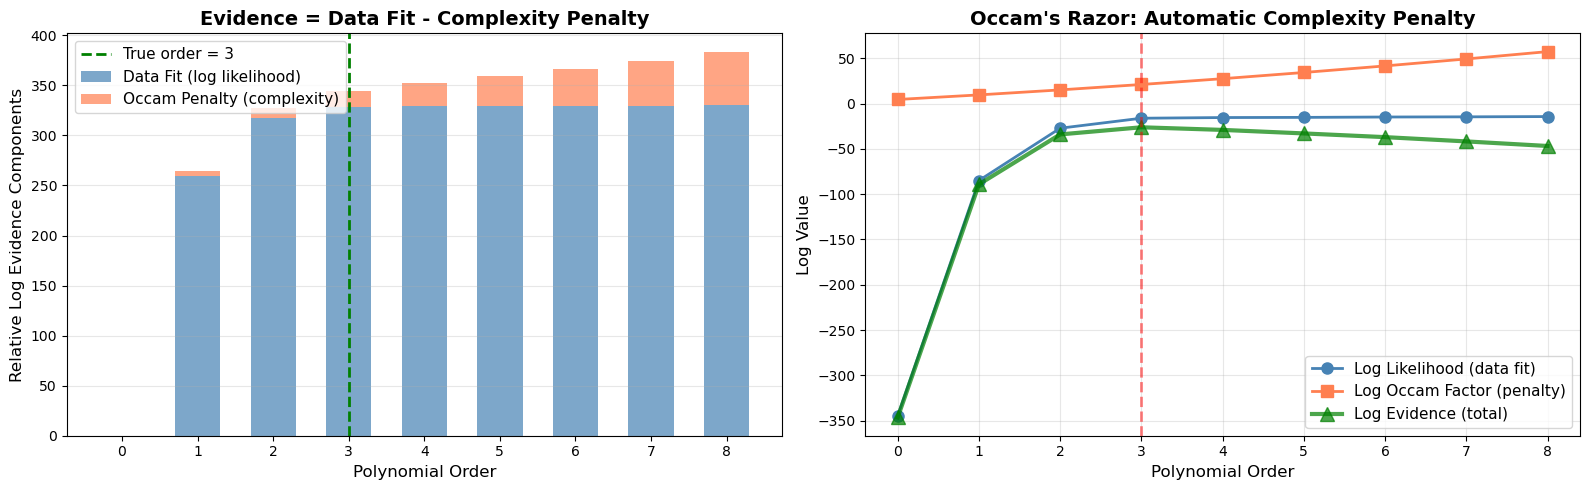


Key Insight: Automatic Occam's Razor
- Lower orders: Poor data fit (low likelihood)
- Order 3: Optimal balance (good fit, not too complex)
- Higher orders: Better fit, BUT penalized for spreading prior probability
  over larger parameter space (Occam factor decreases)

The evidence automatically finds the sweet spot!


In [6]:
# Demonstrate Occam's Razor: Evidence decomposition

# The evidence trades off data fit (likelihood) vs model complexity (prior volume)
# For each model, compute:
# 1. Best-fit likelihood: p(y | mu_k, k)
# 2. Occam factor: ratio of posterior to prior volume

def occam_analysis(x, y, order, sigma2, alpha2):
    """
    Decompose evidence into data fit and Occam factor
    """
    X = design_matrix(x, order)
    N = len(y)
    n_params = order + 1
    
    # Fit model
    mu, Sigma, log_evidence = bayesian_polynomial_fit(x, y, order, sigma2, alpha2)
    
    # Best-fit likelihood
    y_fit = X @ mu
    residuals = y - y_fit
    log_likelihood_best = -N/2 * np.log(2*np.pi*sigma2) - np.sum(residuals**2) / (2*sigma2)
    
    # Occam factor (from ratio of posterior to prior volume)
    # For Gaussian case: log(Occam) ≈ -1/2 log|Sigma| + n_params/2 log(2π alpha²)
    sign, logdet_Sigma = np.linalg.slogdet(Sigma)
    log_occam = -0.5 * logdet_Sigma + n_params/2 * np.log(2*np.pi*alpha2)
    
    return log_evidence, log_likelihood_best, log_occam, n_params

# Analyze each model
print("Evidence Decomposition: Data Fit vs Model Complexity")
print("="*80)
print(f"{'Order':<8} {'# Params':<10} {'Log L(best)':<15} {'Log Occam':<15} {'Log Evidence':<15}")
print("="*80)

occam_data = []
for k in range(max_order + 1):
    log_ev, log_lik, log_occ, n_par = occam_analysis(x, y_obs, k, sigma2, alpha2)
    occam_data.append([k, n_par, log_lik, log_occ, log_ev])
    marker = " ← TRUE" if k == true_order else ""
    print(f"{k:<8} {n_par:<10} {log_lik:<15.2f} {log_occ:<15.2f} {log_ev:<15.2f}{marker}")

occam_data = np.array(occam_data)

# Visualize the trade-off
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left: Stacked bar chart showing evidence decomposition
ax = axes[0]
orders = occam_data[:, 0]
log_likelihoods = occam_data[:, 2]
log_occams = occam_data[:, 3]

# Normalize to show relative contributions
log_like_normalized = log_likelihoods - np.min(log_likelihoods)
log_occam_normalized = log_occams - np.min(log_occams)

width = 0.6
ax.bar(orders, log_like_normalized, width, label='Data Fit (log likelihood)', 
       color='steelblue', alpha=0.7)
ax.bar(orders, log_occam_normalized, width, bottom=log_like_normalized, 
       label='Occam Penalty (complexity)', color='coral', alpha=0.7)

ax.axvline(true_order, color='green', linestyle='--', linewidth=2, 
           label=f'True order = {true_order}')
ax.set_xlabel('Polynomial Order', fontsize=12)
ax.set_ylabel('Relative Log Evidence Components', fontsize=12)
ax.set_title('Evidence = Data Fit - Complexity Penalty', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.set_xticks(orders)
ax.grid(True, alpha=0.3, axis='y')

# Right: Show how components change with order
ax = axes[1]
ax.plot(orders, log_likelihoods, 'o-', linewidth=2, markersize=8, 
        label='Log Likelihood (data fit)', color='steelblue')
ax.plot(orders, log_occams, 's-', linewidth=2, markersize=8, 
        label='Log Occam Factor (penalty)', color='coral')
ax.plot(orders, log_evidences, '^-', linewidth=3, markersize=10, 
        label='Log Evidence (total)', color='green', alpha=0.7)
ax.axvline(true_order, color='red', linestyle='--', linewidth=2, alpha=0.5)

ax.set_xlabel('Polynomial Order', fontsize=12)
ax.set_ylabel('Log Value', fontsize=12)
ax.set_title('Occam\'s Razor: Automatic Complexity Penalty', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.set_xticks(orders)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Key Insight: Automatic Occam's Razor")
print("="*80)
print("- Lower orders: Poor data fit (low likelihood)")
print("- Order 3: Optimal balance (good fit, not too complex)")
print("- Higher orders: Better fit, BUT penalized for spreading prior probability")
print("  over larger parameter space (Occam factor decreases)")
print("\nThe evidence automatically finds the sweet spot!")

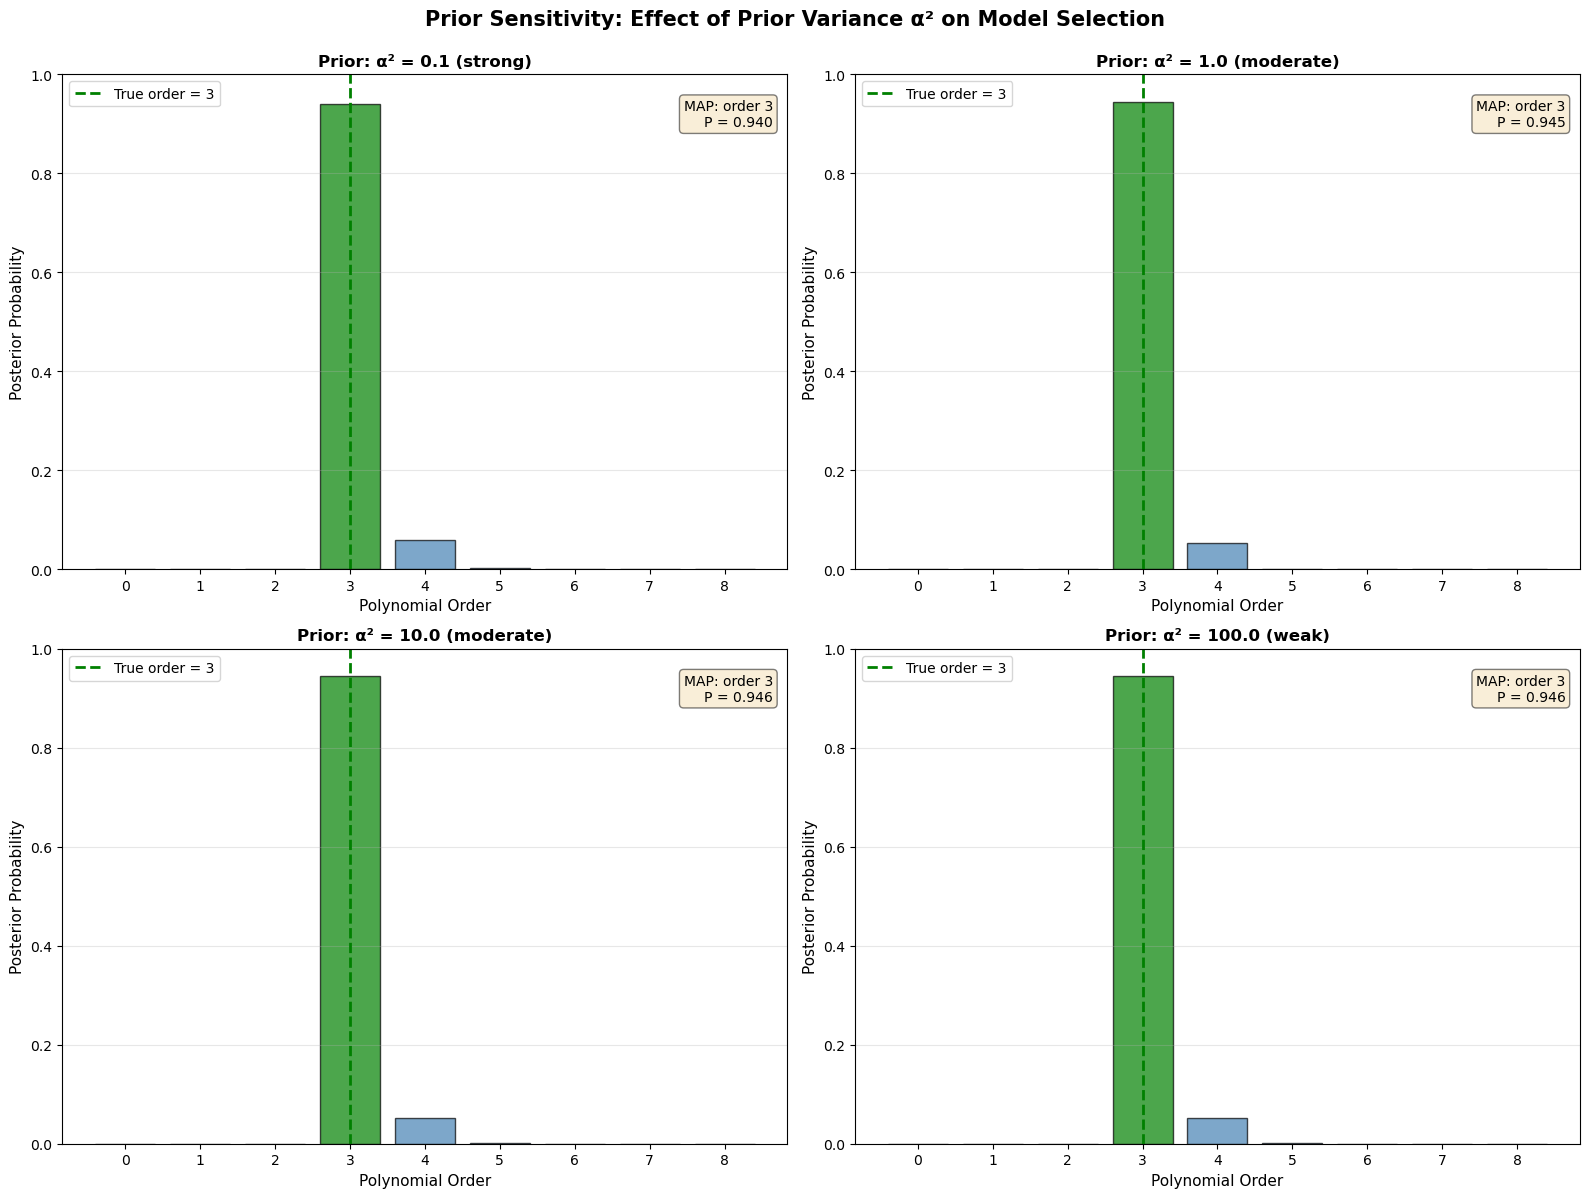

Prior Sensitivity Analysis:
α² =    0.1 (Strong  ): MAP = order 3, P(k=3|data) = 0.940
α² =    1.0 (Moderate): MAP = order 3, P(k=3|data) = 0.945
α² =   10.0 (Moderate): MAP = order 3, P(k=3|data) = 0.946
α² =  100.0 (Weak    ): MAP = order 3, P(k=3|data) = 0.946

Conclusion: With moderate-to-weak priors, model selection is robust.
The data dominates, correctly identifying the true order = 3.


In [7]:
# Sensitivity analysis: Effect of prior strength

# Test different prior variances (α²)
alpha2_values = [0.1, 1.0, 10.0, 100.0]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, alpha2_test in enumerate(alpha2_values):
    ax = axes[idx]
    
    # Compute evidence for each order with this prior
    log_evs = []
    for k in range(max_order + 1):
        _, _, log_ev = bayesian_polynomial_fit(x, y_obs, k, sigma2, alpha2_test)
        log_evs.append(log_ev)
    
    log_evs = np.array(log_evs)
    
    # Compute posterior probabilities
    max_log_ev = np.max(log_evs)
    evs = np.exp(log_evs - max_log_ev)
    post_probs = evs / np.sum(evs)
    
    # Plot
    colors = ['green' if k == true_order else 'steelblue' for k in range(max_order + 1)]
    ax.bar(range(max_order + 1), post_probs, color=colors, alpha=0.7, edgecolor='black')
    ax.axvline(true_order, color='green', linestyle='--', linewidth=2, 
               label=f'True order = {true_order}')
    
    ax.set_xlabel('Polynomial Order', fontsize=11)
    ax.set_ylabel('Posterior Probability', fontsize=11)
    ax.set_title(f'Prior: α² = {alpha2_test:.1f} {"(strong)" if alpha2_test < 1 else "(weak)" if alpha2_test > 10 else "(moderate)"}', 
                 fontsize=12, fontweight='bold')
    ax.set_xticks(range(max_order + 1))
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(0, 1.0)
    
    # Add text showing MAP estimate
    map_order = np.argmax(post_probs)
    ax.text(0.98, 0.95, f'MAP: order {map_order}\nP = {post_probs[map_order]:.3f}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top', 
            horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Prior Sensitivity: Effect of Prior Variance α² on Model Selection', 
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("Prior Sensitivity Analysis:")
print("="*60)
for alpha2_test in alpha2_values:
    log_evs = [bayesian_polynomial_fit(x, y_obs, k, sigma2, alpha2_test)[2] 
               for k in range(max_order + 1)]
    log_evs = np.array(log_evs)
    max_log_ev = np.max(log_evs)
    evs = np.exp(log_evs - max_log_ev)
    post_probs = evs / np.sum(evs)
    map_order = np.argmax(post_probs)
    
    prior_type = "Strong" if alpha2_test < 1 else "Weak" if alpha2_test > 10 else "Moderate"
    print(f"α² = {alpha2_test:6.1f} ({prior_type:8s}): MAP = order {map_order}, P(k=3|data) = {post_probs[3]:.3f}")

print("\nConclusion: With moderate-to-weak priors, model selection is robust.")
print("The data dominates, correctly identifying the true order = 3.")

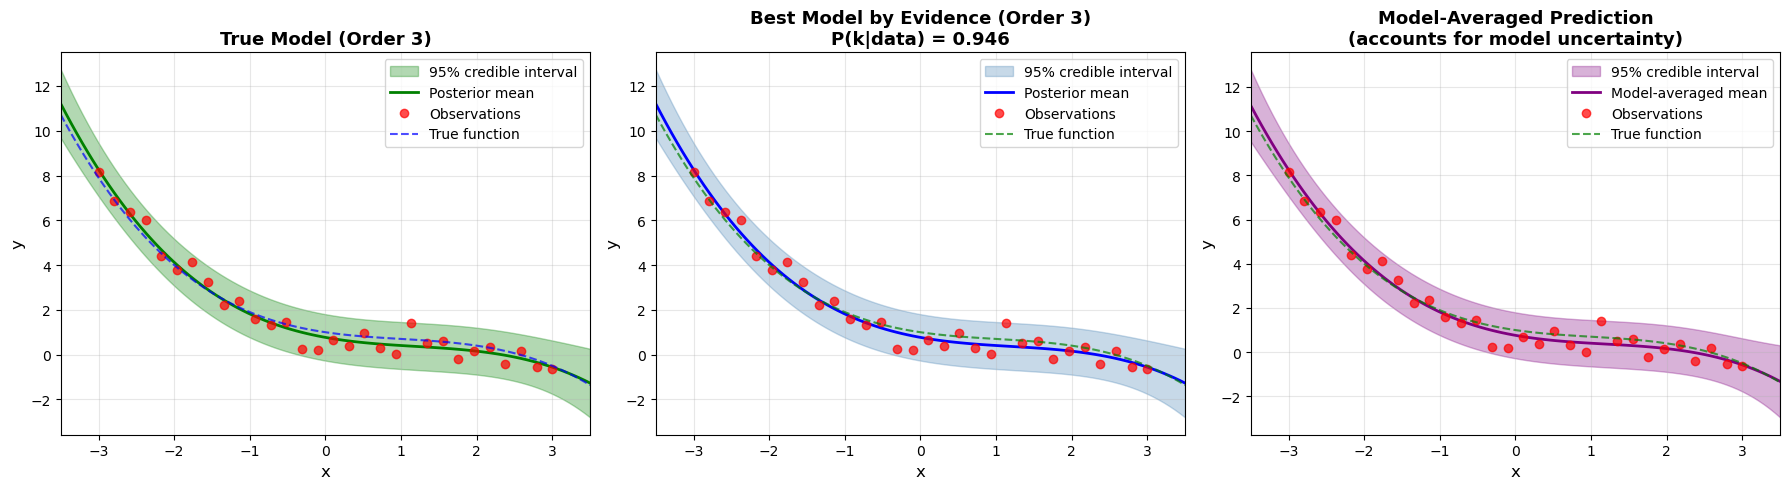

Prediction Comparison:
1. True model (order 3): Uses only the correct model
2. Best model by evidence: Uses single model with highest posterior
3. Model-averaged: Weights predictions by model probabilities

Model averaging provides:
  - More honest uncertainty quantification
  - Robustness to model misspecification
  - Better calibrated prediction intervals


In [8]:
# Posterior predictive distributions with model averaging

# For each order, compute posterior predictive distribution
x_pred = np.linspace(-3.5, 3.5, 100)

# Store predictions from each model
predictions = {}
for k in range(max_order + 1):
    mu_k = results[k]['mu']
    Sigma_k = results[k]['Sigma']
    
    # Mean prediction
    X_pred = design_matrix(x_pred, k)
    y_pred_mean = X_pred @ mu_k
    
    # Predictive variance: σ²(x) = σ² + X(x)^T Σ X(x)
    # (includes both observation noise and parameter uncertainty)
    y_pred_var = sigma2 + np.sum((X_pred @ Sigma_k) * X_pred, axis=1)
    y_pred_std = np.sqrt(y_pred_var)
    
    predictions[k] = {
        'mean': y_pred_mean,
        'std': y_pred_std
    }

# Model-averaged prediction
y_pred_avg = np.zeros(len(x_pred))
y_pred_var_avg = np.zeros(len(x_pred))

for k in range(max_order + 1):
    # Weighted by posterior probability
    y_pred_avg += posterior_probs[k] * predictions[k]['mean']
    # Variance includes both within-model variance and between-model variance
    y_pred_var_avg += posterior_probs[k] * (predictions[k]['std']**2 + predictions[k]['mean']**2)

y_pred_var_avg -= y_pred_avg**2  # Subtract (E[y])² to get Var[y]
y_pred_std_avg = np.sqrt(y_pred_var_avg)

# Visualize predictions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# True model prediction (order 3)
ax = axes[0]
k = true_order
ax.fill_between(x_pred, 
                predictions[k]['mean'] - 2*predictions[k]['std'],
                predictions[k]['mean'] + 2*predictions[k]['std'],
                alpha=0.3, color='green', label='95% credible interval')
ax.plot(x_pred, predictions[k]['mean'], 'g-', linewidth=2, label='Posterior mean')
ax.plot(x, y_obs, 'ro', markersize=6, alpha=0.7, label='Observations')
ax.plot(x_pred, eval_polynomial(x_pred, true_coeffs), 'b--', linewidth=1.5, 
        alpha=0.7, label='True function')
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title(f'True Model (Order {true_order})', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(-3.5, 3.5)

# Best model by evidence
ax = axes[1]
k = np.argmax(log_evidences)
ax.fill_between(x_pred, 
                predictions[k]['mean'] - 2*predictions[k]['std'],
                predictions[k]['mean'] + 2*predictions[k]['std'],
                alpha=0.3, color='steelblue', label='95% credible interval')
ax.plot(x_pred, predictions[k]['mean'], 'b-', linewidth=2, label='Posterior mean')
ax.plot(x, y_obs, 'ro', markersize=6, alpha=0.7, label='Observations')
ax.plot(x_pred, eval_polynomial(x_pred, true_coeffs), 'g--', linewidth=1.5, 
        alpha=0.7, label='True function')
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title(f'Best Model by Evidence (Order {k})\nP(k|data) = {posterior_probs[k]:.3f}', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(-3.5, 3.5)

# Model-averaged prediction
ax = axes[2]
ax.fill_between(x_pred, 
                y_pred_avg - 2*y_pred_std_avg,
                y_pred_avg + 2*y_pred_std_avg,
                alpha=0.3, color='purple', label='95% credible interval')
ax.plot(x_pred, y_pred_avg, 'purple', linewidth=2, label='Model-averaged mean')
ax.plot(x, y_obs, 'ro', markersize=6, alpha=0.7, label='Observations')
ax.plot(x_pred, eval_polynomial(x_pred, true_coeffs), 'g--', linewidth=1.5, 
        alpha=0.7, label='True function')
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title('Model-Averaged Prediction\n(accounts for model uncertainty)', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(-3.5, 3.5)

plt.tight_layout()
plt.show()

print("Prediction Comparison:")
print("="*70)
print("1. True model (order 3): Uses only the correct model")
print("2. Best model by evidence: Uses single model with highest posterior")
print("3. Model-averaged: Weights predictions by model probabilities")
print("\nModel averaging provides:")
print("  - More honest uncertainty quantification")
print("  - Robustness to model misspecification")
print("  - Better calibrated prediction intervals")

## Summary of Polynomial Example

This example demonstrated several key concepts in Bayesian model selection:

### ✅ What We Showed:

1. **Analytical Evidence Computation**
   - For polynomial regression with Gaussian priors/likelihoods, the evidence has a closed-form solution
   - No need for expensive numerical integration or MCMC
   - Exact calculation enables rapid model comparison

2. **Successful Model Identification**
   - Generated data from a 3rd order polynomial
   - Bayesian selection correctly identified order 3 as most probable
   - Demonstrated that the method works when the true model is in the candidate set

3. **Automatic Occam's Razor**
   - Lower orders: penalized for poor data fit (low likelihood)
   - Order 3: optimal balance of fit and complexity
   - Higher orders: penalized despite better fit due to reduced Occam factor
   - **No manual complexity penalty needed** — emerges naturally from Bayesian framework

4. **Evidence Decomposition**
   - Evidence = Data Fit - Complexity Penalty
   - Complexity penalty increases with number of parameters
   - Sweet spot automatically found where evidence is maximized

5. **Prior Sensitivity Analysis**
   - Tested different prior strengths (α²)
   - With weak to moderate priors, results are robust
   - Data dominates the inference when informative

6. **Model Averaging**
   - When multiple models have non-negligible posterior probability
   - Model-averaged predictions account for structural uncertainty
   - Provides more honest uncertainty quantification

### 🔑 Key Takeaways:

- **Evidence-based selection is principled**: Uses probability theory, not ad-hoc criteria
- **Occam's razor is automatic**: Don't need separate complexity penalties (AIC, BIC, etc.)
- **Analytical solutions exist**: For linear models with Gaussian assumptions
- **Model averaging is superior**: When no single model dominates (though here order 3 clearly wins)
- **Prior choice matters**: But with enough data and reasonable priors, inference is robust

### 🔄 Limitations of This Example:

- **Linear model**: Polynomial regression is linear in parameters; most geophysical problems are nonlinear
- **Known noise**: We assumed σ² was known; usually it must be estimated
- **Gaussian assumptions**: Required for analytical evidence; real noise may be non-Gaussian
- **Finite model set**: What if true order > 8? Or data needs different basis functions?

### 🌍 Extension to Geophysics:

For nonlinear problems (earthquake locations, fault slip distributions, velocity models):
- Evidence usually **not** analytically tractable
- Need numerical methods: thermodynamic integration, stepping-stone sampling, RJMCMC
- But the **principles remain the same**: balance fit and complexity via evidence